In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 6
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.531398           0.811961  186.687054    3.127880  1.009872   
1979-02-01  5.328020           0.688896  174.794571   18.541594  0.920831   
1979-03-01  5.432511           0.916124  190.741933   67.690429  0.983327   
1979-04-01  4.792836           1.272056  212.937925  156.223673  0.890723   
1979-05-01  4.819028           2.239776  253.690478  230.950833  1.201308   
...              ...                ...         ...         ...       ...   
2021-04-01  5.383687           1.529497  225.171796  156.567743  1.159049   
2021-05-01  4.777020           2.451088  260.956781  229.604138  1.077705   
2021-06-01  4.771453           4.176458  294.931709  244.702852  1.585094   
2021-07-01  4.754014           5.193846  313.311345  196.774631  1.957911   
2021-08-01  4.635243           5.077386  313.003568  126.146891  2.046782   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  0.892319  273.355237  250.388101        984.633032      15604191.0  
1979-02-01  0.781347  273.121885  247.071202        983.980418      16378929.0  
1979-03-01  0.855266  273.088099  252.954138        985.140468      16521089.0  
1979-04-01  0.705203  273.126062  259.557456        989.314698      15561238.0  
1979-05-01  0.688723  273.393551  269.375118        984.483658      14085613.0  
...              ...         ...         ...               ...             ...  
2021-04-01  0.929777  273.470298  263.146395        985.801841      13840000.0  
2021-05-01  0.575494  273.888627  271.557464        985.606182      12660000.0  
2021-06-01  0.360146  275.245088  278.360921        978.436682      10710000.0  
2021-07-01  0.248088  277.253314  280.413695        978.293303       7690000.0  
2021-08-01  0.235519  278.556142  279.556077        980.453507       5750000.0  

[512 rows x 10 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

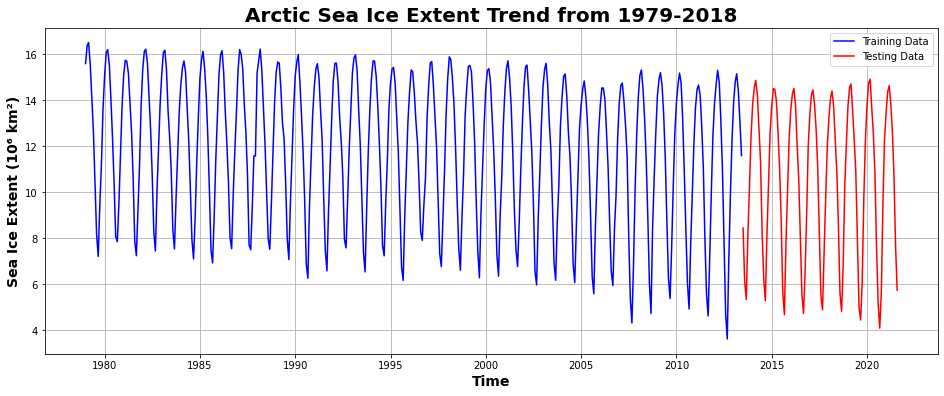

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.3373 - mae: 0.4960 - mse: 0.3373

6/6 [==============================] - 19s 535ms/step - loss: 0.3373 - mae: 0.4960 - mse: 0.3373 - val_loss: 0.1269 - val_mae: 0.3141 - val_mse: 0.1269
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0935 - mae: 0.2560 - mse: 0.0935

6/6 [==============================] - 0s 58ms/step - loss: 0.0935 - mae: 0.2560 - mse: 0.0935 - val_loss: 0.0978 - val_mae: 0.2734 - val_mse: 0.0978
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0931 - mae: 0.2518 - mse: 0.0931

6/6 [==============================] - 0s 45ms/step - loss: 0.0936 - mae: 0.2536 - mse: 0.0936 - val_loss: 0.0895 - val_mae: 0.2698 - val_mse: 0.0895
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0738 - mae: 0.2263 - mse: 0.0738

6/6 [==============================] - 0s 45ms/step - loss: 0.0729 - mae: 0.2247 - mse: 0.0729 - val_loss: 0.0988 - val_mae: 0.2387 - val_mse: 0.0988
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0655 - mae: 0.2152 - mse: 0.0655

6/6 [==============================] - 0s 46ms/step - loss: 0.0662 - mae: 0.2171 - mse: 0.0662 - val_loss: 0.0778 - val_mae: 0.2390 - val_mse: 0.0778
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0650 - mae: 0.2162 - mse: 0.0650

6/6 [==============================] - 0s 44ms/step - loss: 0.0654 - mae: 0.2177 - mse: 0.0654 - val_loss: 0.0953 - val_mae: 0.2374 - val_mse: 0.0953
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0628 - mae: 0.2081 - mse: 0.0628

6/6 [==============================] - 0s 44ms/step - loss: 0.0639 - mae: 0.2106 - mse: 0.0639 - val_loss: 0.0779 - val_mae: 0.2391 - val_mse: 0.0779
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0591 - mae: 0.2045 - mse: 0.0591

6/6 [==============================] - 0s 45ms/step - loss: 0.0597 - mae: 0.2059 - mse: 0.0597 - val_loss: 0.0890 - val_mae: 0.2355 - val_mse: 0.0890
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0612 - mae: 0.2086 - mse: 0.0612

6/6 [==============================] - 0s 46ms/step - loss: 0.0606 - mae: 0.2069 - mse: 0.0606 - val_loss: 0.0808 - val_mae: 0.2366 - val_mse: 0.0808
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0645 - mae: 0.2184 - mse: 0.0645

6/6 [==============================] - 0s 45ms/step - loss: 0.0638 - mae: 0.2179 - mse: 0.0638 - val_loss: 0.0829 - val_mae: 0.2354 - val_mse: 0.0829
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0587 - mae: 0.2075 - mse: 0.0587

6/6 [==============================] - 0s 45ms/step - loss: 0.0595 - mae: 0.2092 - mse: 0.0595 - val_loss: 0.0817 - val_mae: 0.2360 - val_mse: 0.0817
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2082 - mse: 0.0585

6/6 [==============================] - 0s 46ms/step - loss: 0.0593 - mae: 0.2097 - mse: 0.0593 - val_loss: 0.0833 - val_mae: 0.2350 - val_mse: 0.0833
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2081 - mse: 0.0614

6/6 [==============================] - 0s 45ms/step - loss: 0.0615 - mae: 0.2086 - mse: 0.0615 - val_loss: 0.0768 - val_mae: 0.2408 - val_mse: 0.0768
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0642 - mae: 0.2194 - mse: 0.0642

6/6 [==============================] - 0s 46ms/step - loss: 0.0644 - mae: 0.2194 - mse: 0.0644 - val_loss: 0.0846 - val_mae: 0.2348 - val_mse: 0.0846
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0587 - mae: 0.2060 - mse: 0.0587

6/6 [==============================] - 0s 44ms/step - loss: 0.0591 - mae: 0.2051 - mse: 0.0591 - val_loss: 0.0784 - val_mae: 0.2377 - val_mse: 0.0784
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0538 - mae: 0.1987 - mse: 0.0538

6/6 [==============================] - 0s 44ms/step - loss: 0.0555 - mae: 0.2015 - mse: 0.0555 - val_loss: 0.0802 - val_mae: 0.2362 - val_mse: 0.0802
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0596 - mae: 0.2076 - mse: 0.0596

6/6 [==============================] - 0s 47ms/step - loss: 0.0601 - mae: 0.2088 - mse: 0.0601 - val_loss: 0.0816 - val_mae: 0.2350 - val_mse: 0.0816
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0589 - mae: 0.2084 - mse: 0.0589

6/6 [==============================] - 0s 45ms/step - loss: 0.0571 - mae: 0.2043 - mse: 0.0571 - val_loss: 0.0836 - val_mae: 0.2336 - val_mse: 0.0836
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0593 - mae: 0.2077 - mse: 0.0593

6/6 [==============================] - 0s 43ms/step - loss: 0.0580 - mae: 0.2053 - mse: 0.0580 - val_loss: 0.0794 - val_mae: 0.2325 - val_mse: 0.0794
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0568 - mae: 0.2057 - mse: 0.0568

6/6 [==============================] - 0s 44ms/step - loss: 0.1490 - mae: 0.2270 - mse: 0.1490 - val_loss: 0.0888 - val_mae: 0.2344 - val_mse: 0.0888
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0631 - mae: 0.2109 - mse: 0.0631

6/6 [==============================] - 0s 44ms/step - loss: 0.0625 - mae: 0.2103 - mse: 0.0625 - val_loss: 0.0774 - val_mae: 0.2393 - val_mse: 0.0774
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0641 - mae: 0.2144 - mse: 0.0641

6/6 [==============================] - 0s 44ms/step - loss: 0.0639 - mae: 0.2144 - mse: 0.0639 - val_loss: 0.0791 - val_mae: 0.2508 - val_mse: 0.0791
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0728 - mae: 0.2252 - mse: 0.0728

6/6 [==============================] - 0s 47ms/step - loss: 0.0695 - mae: 0.2193 - mse: 0.0695 - val_loss: 0.0913 - val_mae: 0.2361 - val_mse: 0.0913
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2106 - mse: 0.0614

6/6 [==============================] - 0s 47ms/step - loss: 0.0628 - mae: 0.2139 - mse: 0.0628 - val_loss: 0.0803 - val_mae: 0.2335 - val_mse: 0.0803
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1034 - mae: 0.2551 - mse: 0.1034

6/6 [==============================] - 0s 44ms/step - loss: 0.1014 - mae: 0.2540 - mse: 0.1014 - val_loss: 0.0807 - val_mae: 0.2535 - val_mse: 0.0807
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1083 - mae: 0.2679 - mse: 0.1083

6/6 [==============================] - 0s 49ms/step - loss: 0.1061 - mae: 0.2651 - mse: 0.1061 - val_loss: 0.0772 - val_mae: 0.2400 - val_mse: 0.0772
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0868 - mae: 0.2500 - mse: 0.0868

6/6 [==============================] - 0s 45ms/step - loss: 0.0867 - mae: 0.2488 - mse: 0.0867 - val_loss: 0.0980 - val_mae: 0.2385 - val_mse: 0.0980
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0751 - mae: 0.2280 - mse: 0.0751

6/6 [==============================] - 0s 46ms/step - loss: 0.0737 - mae: 0.2263 - mse: 0.0737 - val_loss: 0.0770 - val_mae: 0.2405 - val_mse: 0.0770
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0665 - mae: 0.2162 - mse: 0.0665

6/6 [==============================] - 0s 45ms/step - loss: 0.0655 - mae: 0.2138 - mse: 0.0655 - val_loss: 0.0906 - val_mae: 0.2361 - val_mse: 0.0906
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0668 - mae: 0.2162 - mse: 0.0668

6/6 [==============================] - 0s 44ms/step - loss: 0.0694 - mae: 0.2214 - mse: 0.0694 - val_loss: 0.0785 - val_mae: 0.2379 - val_mse: 0.0785
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0651 - mae: 0.2168 - mse: 0.0651

6/6 [==============================] - 0s 44ms/step - loss: 0.0637 - mae: 0.2140 - mse: 0.0637 - val_loss: 0.0818 - val_mae: 0.2343 - val_mse: 0.0818
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0640 - mae: 0.2117 - mse: 0.0640

6/6 [==============================] - 0s 47ms/step - loss: 0.0638 - mae: 0.2116 - mse: 0.0638 - val_loss: 0.0757 - val_mae: 0.2349 - val_mse: 0.0757
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0586 - mae: 0.1989 - mse: 0.0586

6/6 [==============================] - 0s 45ms/step - loss: 0.0596 - mae: 0.1995 - mse: 0.0596 - val_loss: 0.0706 - val_mae: 0.2219 - val_mse: 0.0706
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0497 - mae: 0.1838 - mse: 0.0497

6/6 [==============================] - 0s 48ms/step - loss: 0.0497 - mae: 0.1851 - mse: 0.0497 - val_loss: 0.0885 - val_mae: 0.2423 - val_mse: 0.0885
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0612 - mae: 0.2085 - mse: 0.0612

6/6 [==============================] - 0s 46ms/step - loss: 0.0608 - mae: 0.2077 - mse: 0.0608 - val_loss: 0.0693 - val_mae: 0.2144 - val_mse: 0.0693
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0462 - mae: 0.1752 - mse: 0.0462

6/6 [==============================] - 0s 47ms/step - loss: 0.0457 - mae: 0.1743 - mse: 0.0457 - val_loss: 0.0337 - val_mae: 0.1408 - val_mse: 0.0337
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0230 - mae: 0.1221 - mse: 0.0230

6/6 [==============================] - 0s 48ms/step - loss: 0.0222 - mae: 0.1196 - mse: 0.0222 - val_loss: 0.0133 - val_mae: 0.0869 - val_mse: 0.0133
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0145 - mae: 0.0948 - mse: 0.0145

6/6 [==============================] - 0s 47ms/step - loss: 0.0145 - mae: 0.0949 - mse: 0.0145 - val_loss: 0.0330 - val_mae: 0.1440 - val_mse: 0.0330
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0180 - mae: 0.1059 - mse: 0.0180

6/6 [==============================] - 0s 46ms/step - loss: 0.0175 - mae: 0.1039 - mse: 0.0175 - val_loss: 0.0315 - val_mae: 0.1581 - val_mse: 0.0315
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0153 - mae: 0.0974 - mse: 0.0153

6/6 [==============================] - 0s 45ms/step - loss: 0.0155 - mae: 0.0979 - mse: 0.0155 - val_loss: 0.0125 - val_mae: 0.0858 - val_mse: 0.0125
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0136 - mae: 0.0910 - mse: 0.0136

6/6 [==============================] - 0s 45ms/step - loss: 0.0139 - mae: 0.0926 - mse: 0.0139 - val_loss: 0.0101 - val_mae: 0.0734 - val_mse: 0.0101
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0114 - mae: 0.0853 - mse: 0.0114

6/6 [==============================] - 0s 47ms/step - loss: 0.0114 - mae: 0.0855 - mse: 0.0114 - val_loss: 0.0083 - val_mae: 0.0670 - val_mse: 0.0083
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0089 - mae: 0.0758 - mse: 0.0089

6/6 [==============================] - 0s 48ms/step - loss: 0.0089 - mae: 0.0759 - mse: 0.0089 - val_loss: 0.0102 - val_mae: 0.0794 - val_mse: 0.0102
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0086 - mae: 0.0712 - mse: 0.0086

6/6 [==============================] - 0s 46ms/step - loss: 0.0086 - mae: 0.0712 - mse: 0.0086 - val_loss: 0.0100 - val_mae: 0.0918 - val_mse: 0.0100
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0083 - mae: 0.0738 - mse: 0.0083

6/6 [==============================] - 0s 47ms/step - loss: 0.0087 - mae: 0.0750 - mse: 0.0087 - val_loss: 0.0045 - val_mae: 0.0529 - val_mse: 0.0045
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0075 - mae: 0.0678 - mse: 0.0075

6/6 [==============================] - 0s 47ms/step - loss: 0.0075 - mae: 0.0688 - mse: 0.0075 - val_loss: 0.0068 - val_mae: 0.0697 - val_mse: 0.0068
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0614 - mse: 0.0059

6/6 [==============================] - 0s 48ms/step - loss: 0.0061 - mae: 0.0622 - mse: 0.0061 - val_loss: 0.0080 - val_mae: 0.0728 - val_mse: 0.0080
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0664 - mse: 0.0070

6/6 [==============================] - 0s 49ms/step - loss: 0.0067 - mae: 0.0653 - mse: 0.0067 - val_loss: 0.0076 - val_mae: 0.0738 - val_mse: 0.0076
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0071 - mae: 0.0677 - mse: 0.0071

6/6 [==============================] - 0s 46ms/step - loss: 0.0069 - mae: 0.0665 - mse: 0.0069 - val_loss: 0.0066 - val_mae: 0.0670 - val_mse: 0.0066
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0668 - mse: 0.0068

6/6 [==============================] - 0s 46ms/step - loss: 0.0068 - mae: 0.0663 - mse: 0.0068 - val_loss: 0.0066 - val_mae: 0.0685 - val_mse: 0.0066
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0633 - mse: 0.0062

6/6 [==============================] - 0s 47ms/step - loss: 0.0063 - mae: 0.0632 - mse: 0.0063 - val_loss: 0.0068 - val_mae: 0.0676 - val_mse: 0.0068
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0071 - mae: 0.0661 - mse: 0.0071

6/6 [==============================] - 0s 46ms/step - loss: 0.0070 - mae: 0.0652 - mse: 0.0070 - val_loss: 0.0060 - val_mae: 0.0653 - val_mse: 0.0060
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0644 - mse: 0.0064

6/6 [==============================] - 0s 46ms/step - loss: 0.0066 - mae: 0.0651 - mse: 0.0066 - val_loss: 0.0112 - val_mae: 0.0964 - val_mse: 0.0112
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0626 - mse: 0.0062

6/6 [==============================] - 0s 48ms/step - loss: 0.0065 - mae: 0.0638 - mse: 0.0065 - val_loss: 0.0060 - val_mae: 0.0587 - val_mse: 0.0060
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0601 - mse: 0.0058

6/6 [==============================] - 0s 48ms/step - loss: 0.0058 - mae: 0.0601 - mse: 0.0058 - val_loss: 0.0064 - val_mae: 0.0675 - val_mse: 0.0064
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0590 - mse: 0.0055

6/6 [==============================] - 0s 46ms/step - loss: 0.0055 - mae: 0.0583 - mse: 0.0055 - val_loss: 0.0053 - val_mae: 0.0574 - val_mse: 0.0053
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0588 - mse: 0.0054

6/6 [==============================] - 0s 45ms/step - loss: 0.0054 - mae: 0.0584 - mse: 0.0054 - val_loss: 0.0069 - val_mae: 0.0636 - val_mse: 0.0069
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0607 - mse: 0.0056

6/6 [==============================] - 0s 47ms/step - loss: 0.0056 - mae: 0.0609 - mse: 0.0056 - val_loss: 0.0062 - val_mae: 0.0627 - val_mse: 0.0062
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0610 - mse: 0.0059

6/6 [==============================] - 0s 43ms/step - loss: 0.0058 - mae: 0.0601 - mse: 0.0058 - val_loss: 0.0055 - val_mae: 0.0534 - val_mse: 0.0055
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0612 - mse: 0.0057

6/6 [==============================] - 0s 47ms/step - loss: 0.0057 - mae: 0.0607 - mse: 0.0057 - val_loss: 0.0062 - val_mae: 0.0614 - val_mse: 0.0062
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0568 - mse: 0.0049

6/6 [==============================] - 0s 45ms/step - loss: 0.0048 - mae: 0.0563 - mse: 0.0048 - val_loss: 0.0061 - val_mae: 0.0625 - val_mse: 0.0061
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0626 - mse: 0.0062

6/6 [==============================] - 0s 46ms/step - loss: 0.0063 - mae: 0.0633 - mse: 0.0063 - val_loss: 0.0069 - val_mae: 0.0703 - val_mse: 0.0069
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0631 - mse: 0.0064

6/6 [==============================] - 0s 48ms/step - loss: 0.0062 - mae: 0.0621 - mse: 0.0062 - val_loss: 0.0111 - val_mae: 0.0910 - val_mse: 0.0111
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0599 - mse: 0.0057

6/6 [==============================] - 0s 48ms/step - loss: 0.0056 - mae: 0.0595 - mse: 0.0056 - val_loss: 0.0045 - val_mae: 0.0502 - val_mse: 0.0045
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0621 - mse: 0.0059

6/6 [==============================] - 0s 47ms/step - loss: 0.0061 - mae: 0.0630 - mse: 0.0061 - val_loss: 0.0068 - val_mae: 0.0667 - val_mse: 0.0068
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0559 - mse: 0.0047

6/6 [==============================] - 0s 46ms/step - loss: 0.0046 - mae: 0.0549 - mse: 0.0046 - val_loss: 0.0063 - val_mae: 0.0566 - val_mse: 0.0063
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0547 - mse: 0.0050

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0555 - mse: 0.0050 - val_loss: 0.0069 - val_mae: 0.0664 - val_mse: 0.0069
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0536 - mse: 0.0048

6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - mae: 0.0542 - mse: 0.0049 - val_loss: 0.0057 - val_mae: 0.0556 - val_mse: 0.0057
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0536 - mse: 0.0047

6/6 [==============================] - 0s 46ms/step - loss: 0.0047 - mae: 0.0542 - mse: 0.0047 - val_loss: 0.0038 - val_mae: 0.0459 - val_mse: 0.0038
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0564 - mse: 0.0051

6/6 [==============================] - 0s 46ms/step - loss: 0.0053 - mae: 0.0577 - mse: 0.0053 - val_loss: 0.0077 - val_mae: 0.0758 - val_mse: 0.0077
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0601 - mse: 0.0055

6/6 [==============================] - 0s 44ms/step - loss: 0.0055 - mae: 0.0597 - mse: 0.0055 - val_loss: 0.0064 - val_mae: 0.0612 - val_mse: 0.0064
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - mae: 0.0549 - mse: 0.0052

6/6 [==============================] - 0s 47ms/step - loss: 0.0054 - mae: 0.0557 - mse: 0.0054 - val_loss: 0.0052 - val_mae: 0.0538 - val_mse: 0.0052
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0593 - mse: 0.0058

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0598 - mse: 0.0060 - val_loss: 0.0102 - val_mae: 0.0923 - val_mse: 0.0102
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0557 - mse: 0.0049

6/6 [==============================] - 0s 46ms/step - loss: 0.0048 - mae: 0.0548 - mse: 0.0048 - val_loss: 0.0063 - val_mae: 0.0638 - val_mse: 0.0063
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0525 - mse: 0.0047

6/6 [==============================] - 0s 46ms/step - loss: 0.0047 - mae: 0.0532 - mse: 0.0047 - val_loss: 0.0057 - val_mae: 0.0564 - val_mse: 0.0057
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0563 - mse: 0.0051

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0564 - mse: 0.0050 - val_loss: 0.0056 - val_mae: 0.0594 - val_mse: 0.0056
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0539 - mse: 0.0046

6/6 [==============================] - 0s 46ms/step - loss: 0.0047 - mae: 0.0540 - mse: 0.0047 - val_loss: 0.0063 - val_mae: 0.0659 - val_mse: 0.0063
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0511 - mse: 0.0041

6/6 [==============================] - 0s 48ms/step - loss: 0.0040 - mae: 0.0509 - mse: 0.0040 - val_loss: 0.0055 - val_mae: 0.0562 - val_mse: 0.0055
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0521 - mse: 0.0042

6/6 [==============================] - 0s 48ms/step - loss: 0.0044 - mae: 0.0529 - mse: 0.0044 - val_loss: 0.0095 - val_mae: 0.0804 - val_mse: 0.0095
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0550 - mse: 0.0049

6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - mae: 0.0554 - mse: 0.0049 - val_loss: 0.0055 - val_mae: 0.0555 - val_mse: 0.0055
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0555 - mse: 0.0051

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0552 - mse: 0.0050 - val_loss: 0.0048 - val_mae: 0.0514 - val_mse: 0.0048
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0536 - mse: 0.0045

6/6 [==============================] - 0s 47ms/step - loss: 0.0047 - mae: 0.0548 - mse: 0.0047 - val_loss: 0.0071 - val_mae: 0.0725 - val_mse: 0.0071
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0548 - mse: 0.0047

6/6 [==============================] - 0s 47ms/step - loss: 0.0047 - mae: 0.0545 - mse: 0.0047 - val_loss: 0.0056 - val_mae: 0.0572 - val_mse: 0.0056
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0545 - mse: 0.0047

6/6 [==============================] - 0s 49ms/step - loss: 0.0046 - mae: 0.0542 - mse: 0.0046 - val_loss: 0.0055 - val_mae: 0.0567 - val_mse: 0.0055
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0531 - mse: 0.0048

6/6 [==============================] - 0s 46ms/step - loss: 0.0048 - mae: 0.0529 - mse: 0.0048 - val_loss: 0.0079 - val_mae: 0.0772 - val_mse: 0.0079
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0559 - mse: 0.0050

6/6 [==============================] - 0s 46ms/step - loss: 0.0050 - mae: 0.0555 - mse: 0.0050 - val_loss: 0.0046 - val_mae: 0.0539 - val_mse: 0.0046
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0545 - mse: 0.0048

6/6 [==============================] - 0s 47ms/step - loss: 0.0047 - mae: 0.0541 - mse: 0.0047 - val_loss: 0.0092 - val_mae: 0.0812 - val_mse: 0.0092
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0488 - mse: 0.0039

6/6 [==============================] - 0s 47ms/step - loss: 0.0039 - mae: 0.0483 - mse: 0.0039 - val_loss: 0.0065 - val_mae: 0.0658 - val_mse: 0.0065
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0529 - mse: 0.0043

6/6 [==============================] - 0s 48ms/step - loss: 0.0043 - mae: 0.0526 - mse: 0.0043 - val_loss: 0.0048 - val_mae: 0.0537 - val_mse: 0.0048
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0496 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0494 - mse: 0.0040 - val_loss: 0.0098 - val_mae: 0.0862 - val_mse: 0.0098
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0513 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0515 - mse: 0.0041 - val_loss: 0.0051 - val_mae: 0.0545 - val_mse: 0.0051
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0544 - mse: 0.0046

6/6 [==============================] - 0s 47ms/step - loss: 0.0045 - mae: 0.0537 - mse: 0.0045 - val_loss: 0.0071 - val_mae: 0.0738 - val_mse: 0.0071
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0475 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0035 - mae: 0.0469 - mse: 0.0035 - val_loss: 0.0049 - val_mae: 0.0508 - val_mse: 0.0049
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0515 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0519 - mse: 0.0041 - val_loss: 0.0094 - val_mae: 0.0834 - val_mse: 0.0094
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0512 - mse: 0.0042

6/6 [==============================] - 0s 47ms/step - loss: 0.0043 - mae: 0.0523 - mse: 0.0043 - val_loss: 0.0048 - val_mae: 0.0529 - val_mse: 0.0048
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0491 - mse: 0.0038

6/6 [==============================] - 0s 46ms/step - loss: 0.0038 - mae: 0.0492 - mse: 0.0038 - val_loss: 0.0066 - val_mae: 0.0624 - val_mse: 0.0066
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0439 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0452 - mse: 0.0033 - val_loss: 0.0049 - val_mae: 0.0507 - val_mse: 0.0049
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0512 - mse: 0.0042

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0508 - mse: 0.0043 - val_loss: 0.0053 - val_mae: 0.0574 - val_mse: 0.0053
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0493 - mse: 0.0038

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0501 - mse: 0.0040 - val_loss: 0.0088 - val_mae: 0.0787 - val_mse: 0.0088
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0497 - mse: 0.0039

6/6 [==============================] - 0s 47ms/step - loss: 0.0038 - mae: 0.0488 - mse: 0.0038 - val_loss: 0.0040 - val_mae: 0.0494 - val_mse: 0.0040


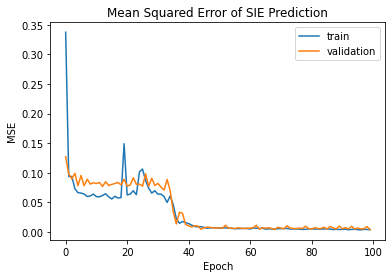

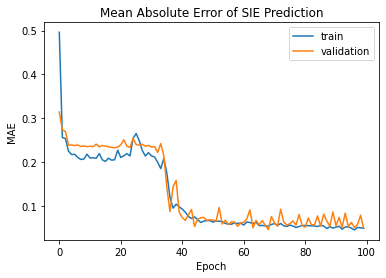

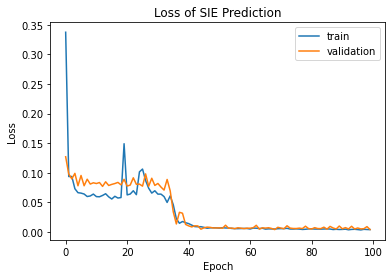

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


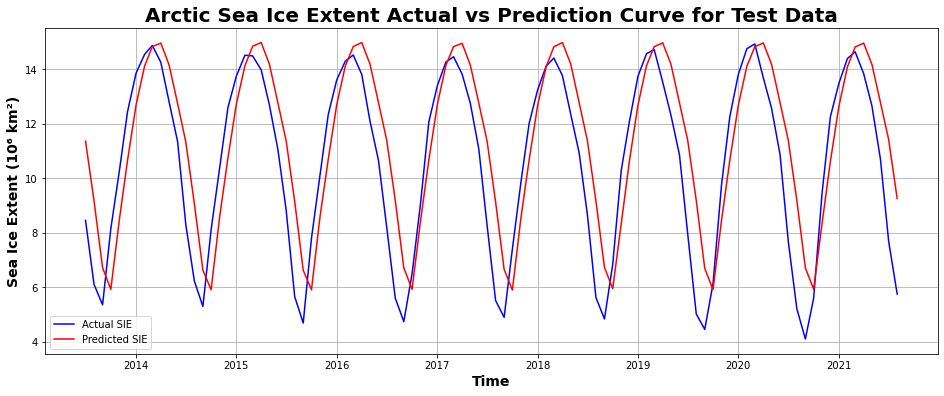

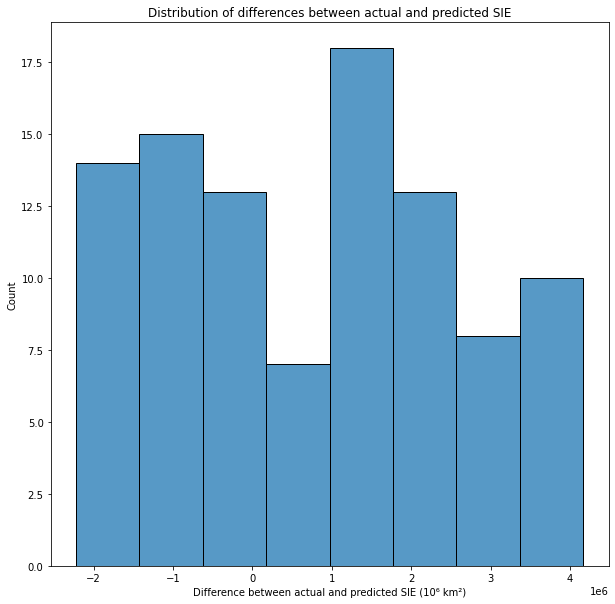

MSE :  3653592954421.814 (10⁶ km²)
MSPE : 7.737 %
RMSE :  1911437.4053109388 (10⁶ km²)
RMSPE : 27.815 %
MAE :  1611932.8214285714 (10⁶ km²)
MAPE :  16.328 %
R2 :  59.321


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass